In [2]:
from google.colab import auth
import tensorflow_io as tfio # ! pip install -q tensorflow-io
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm 

Authenticate user:

```
auth.authenticate_user()
```

Download needed packages:

```
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse
```

Mount the bucket to colab:


```
!mkdir DataSet
!gcsfuse autovc_datasets DataSet
```




In [ ]:
auth.authenticate_user()

In [ ]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  97576      0 --:--:-- --:--:-- --:--:-- 97576
OK
34 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 10.6 MB of archives.
After this operation, 22.7 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 160983 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.34.1_amd64.deb ...
Unpacking gcsfuse (0.34.1) ...
Setting up gcsfuse (0.34.1) ...


In [ ]:
!mkdir DataSet
!gcsfuse autovc_datasets DataSet

2021/04/12 07:50:45.219466 Using mount point: /content/DataSet
2021/04/12 07:50:45.227706 Opening GCS connection...
2021/04/12 07:50:45.713923 Mounting file system "autovc_datasets"...
2021/04/12 07:50:45.734985 File system has been successfully mounted.




```
# Dit is opgemaakt als code
```

## Find all files within directory

In [3]:
path = "DataSet/librispeech/downloads/extracted"

In [4]:
import os

def get_all_files(path, max_files=100000000):
  """Find all files within the path and deeper that end with .flac"""
  file_names = []
  for root, dirs, files in os.walk(path):
      for file in files:
          if file.endswith(".flac"):
            if len(file_names) == max_files:
              return file_names
            file_names.append(os.path.join(root, file))


## Step by step processing

(225360, 1)
tf.Tensor([  9010 220181], shape=(2,), dtype=int64)
tf.Tensor(9010, shape=(), dtype=int64) tf.Tensor(220181, shape=(), dtype=int64)
(211171,)


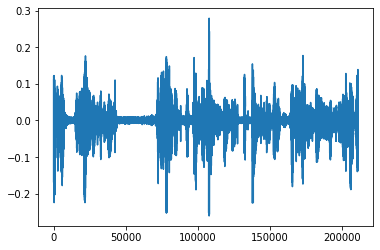

(211171,)


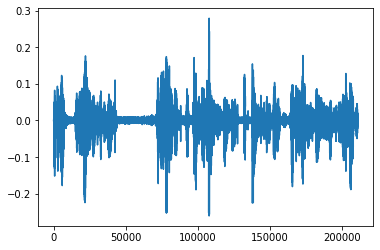

(825, 257)


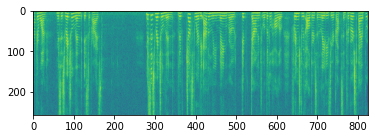

In [54]:
# Read the Audio Tensor from file
file_path = file_names[0]
audio_tensor = tfio.audio.AudioIOTensor(file_path).to_tensor()

# Plot raw audio signal
plt.figure()
plt.plot(audio.numpy())


# cast to floating
tensor = tf.cast(audio_tensor, tf.float32) / 32768.0
print(tensor.shape)
tensor = tensor[:, 0]

# Trim the noise (begin and end)
position = tfio.experimental.audio.trim(tensor, axis=0, epsilon=0.1)
print(position)
start, stop = position[0], position[1]
print(start, stop)

processed = tensor[start:stop]
print(processed.shape)

plt.plot(processed.numpy())
plt.show()


# Fade in and out
fade = tfio.experimental.audio.fade(
    processed, fade_in=1000, fade_out=2000, mode="logarithmic"
)
print(fade.shape)
plt.plot(fade.numpy())
plt.show()

# Spectogram
spectogram = tfio.experimental.audio.spectrogram(
      fade, nfft=512, window=512, stride=256
  )
print(spectogram.shape)
plt.imshow(tf.math.log(spectogram).numpy().T)

# Mel spectrogram
mel_spectrogram = tfio.experimental.audio.melscale(
    spectogram, rate=16000, mels=128, fmin=0, fmax=8000)

print(mel_spectrogram.shape)
plt.figure(figsize=(15,4))
data = tf.math.log(mel_spectrogram).numpy()
plt.imshow(data, aspect="auto")
plt.show()

## Process files

In [7]:
def load_audio(file_path):
    """Load and decode flac files"""
    audio = tf.io.read_file(file_path)
    audio = tfio.audio.decode_flac(audio, dtype=tf.int16) #TODO: check datatype
    return audio

def build_file_dataset(file_paths):
    """Create a DataSet object containing all file paths"""
    file_paths = tf.convert_to_tensor(file_paths, dtype=tf.string)
    dataset = tf.data.Dataset.list_files(file_paths).prefetch(1)
    return dataset

def transform_files(files, process_fn):
    """Apply processing step to dataset"""
    files = files.map(process_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return files

def process_files(file_path):
  """Load audio file from disk and perform processing step to get mel spectorgram"""
  audio_tensor = load_audio(file_path)

  tensor = tf.cast(audio_tensor, tf.float32) / 32768.0
  tensor = tensor[:, 0]

  spectogram = tfio.experimental.audio.spectrogram(
      tensor, nfft=512, window=512, stride=256
  )
  mel_spectogram = tfio.experimental.audio.melscale(
      spectogram, rate=16000, mels=128, fmin=0, fmax=8000
  )

  return mel_spectogram

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Get all flac filenames
%time file_names = get_all_files(path, max_files=1000)

# Create a dataset that contains all the file names
%time file_data_set = build_file_dataset(file_names)

# apply transformation
%time processed_files = transform_files(file_data_set, process_files)


CPU times: user 52.5 ms, sys: 13.3 ms, total: 65.9 ms
Wall time: 8.41 s
CPU times: user 61.4 ms, sys: 102 ms, total: 163 ms
Wall time: 662 ms
CPU times: user 273 ms, sys: 1.88 ms, total: 275 ms
Wall time: 282 ms


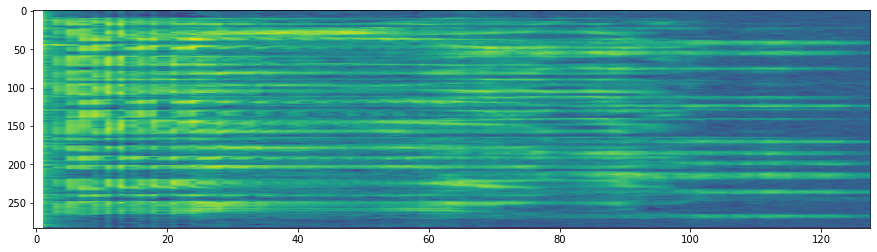

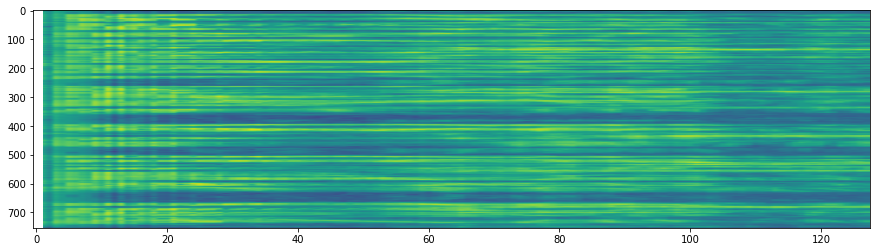

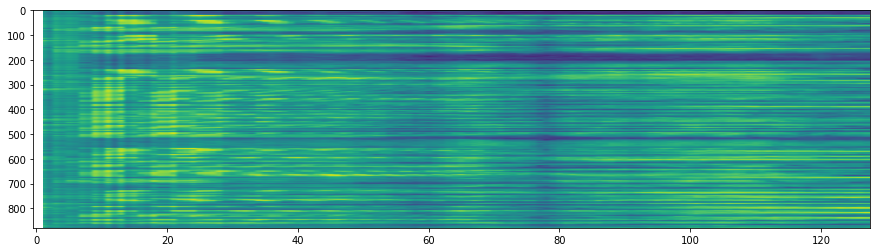

In [18]:
for i in processed_files.take(3):
  plt.figure(figsize=(15,4))
  data = tf.math.log(i).numpy()
  plt.imshow(data, aspect="auto")
  plt.show()

## Write files to disk